In [73]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import h5py
import networkx as nx
import os
import pickle
import time
from tqdm.notebook import tqdm

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model
from markov_utilities import (
    calculate_sequence_probabilities,
    compute_myopic_entropy_from_MSP,
    epsilon_machine_to_graph,
    get_recurrent_subgraph,
    to_mixed_state_presentation,
    get_recurrent_subgraph,
    calculate_empirical_sequence_probabilities,
    create_transition_matrix
)

from entropy_analysis import (
    compute_conditional_entropy,
    compute_empirical_conditional_entropy,
    inverse_binary_entropy,

)

from error_analysis import (
    compute_minimum_error,
)

from visualization import visualize_graph
from processes import RRXORProcess, GoldenMeanProcess, ZeroOneRProcess, EvenProcess, Process


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


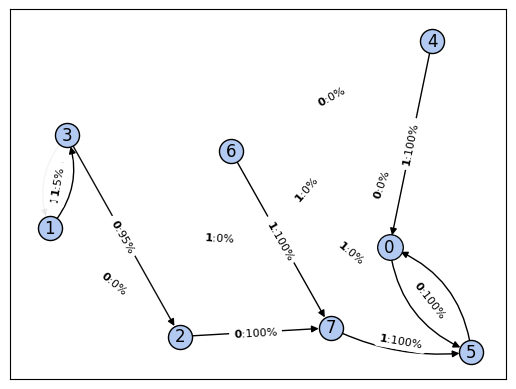

In [43]:
randprocess = Process.random()
g = epsilon_machine_to_graph(randprocess.T)
visualize_graph(g, draw_mixed_state=True)

In [90]:
# %% CONFIGURATION
CONFIG = {
    'NUM_SYMBOLS': 2,
    'ALPHA': 1.0,
    'NUM_STATES_LIST': [30, 300, 3000],
    'NUM_REPEATS': 100,
    'NUM_EMISSIONS': 1000000,
    'HDF5_BASE_PATH': '../data/results.h5'
}

In [91]:
# %% FUNCTION DEFINITIONS
def generate_and_save_data(num_states, num_repeats, num_symbols, alpha, hdf5_filepath_base):
    """
    Generate epsilon machines, emissions, and results, then save to HDF5.
    """
    hdf5_filepath = hdf5_filepath_base.replace('.h5', f'_{num_states}_states.h5')

    with h5py.File(hdf5_filepath, 'a') as f:

        for repeats in tqdm(range(num_repeats)):
            group_name = f"repeat_{repeats}"
            
            datasets_to_check = ['epsilon_machine', 'emissions', 'results']
            if group_name in f and all(dataset in f[group_name] for dataset in datasets_to_check):
                continue

            # If group exists but not all datasets are there, delete the group to recreate
            if group_name in f:
                del f[group_name]

            epsilon_machine = Process.random(num_states, num_symbols, alpha)
            emissions = epsilon_machine.generate(CONFIG['NUM_EMISSIONS'])
            conditional_entropies = compute_empirical_conditional_entropy(emissions, 15)

            group = f.create_group(group_name)
            group.create_dataset('epsilon_machine', data=epsilon_machine.T, compression="gzip", compression_opts=9)
            group.create_dataset('emissions', data=emissions, dtype='uint8')

            results = []
            for block_size, cond_entropy in enumerate(conditional_entropies, 1):
                inverse_entropy = inverse_binary_entropy(cond_entropy)
                min_error = compute_minimum_error(epsilon_machine.T)
                error_ratio = (inverse_entropy - min_error) / min_error
                results.append({
                    "Block Size": block_size,
                    "Conditional Entropy": cond_entropy,
                    "Inverse Binary Entropy": inverse_entropy,
                    "Minimum Error": min_error,
                    "Error Ratio": error_ratio
                })

            results_df = pd.DataFrame(results)
            rec_array = results_df.to_records(index=False)
            group.create_dataset('results', data=rec_array)


In [93]:
for num_states in CONFIG['NUM_STATES_LIST']:
    generate_and_save_data(
        num_states=num_states, 
        num_repeats=CONFIG['NUM_REPEATS'], 
        num_symbols=CONFIG['NUM_SYMBOLS'], 
        alpha=CONFIG['ALPHA'], 
        hdf5_filepath_base=CONFIG['HDF5_BASE_PATH']
    )

  0%|          | 0/100 [00:00<?, ?it/s]

(30, 2)
(30, 2)
(30, 2)


KeyboardInterrupt: 

In [96]:
def extract_and_plot_data(num_states_list, hdf5_filepath_base):
    """
    Extract data from HDF5 files and plot the error ratio vs block size and 
    the conditional entropy vs block size.
    """
    all_results = []

    for num_states in num_states_list:
        hdf5_filepath = hdf5_filepath_base.replace('.h5', f'_{num_states}_states.h5')
        
        with h5py.File(hdf5_filepath, 'r') as f:
            for group_name in f:
                results_array = f[group_name]['results'][:]
                df = pd.DataFrame(results_array)
                df['Number of States'] = num_states
                all_results.append(df)

    final_df = pd.concat(all_results, ignore_index=True)

    # Plotting Error Ratio vs Block Size
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=final_df, x='Block Size', y='Error Ratio', hue='Number of States',
                  palette='bright', errorbar=('ci', 90))
    plt.title('Error Ratio vs Block Size')
    plt.grid(True)

    # Plotting Conditional Entropy vs Block Size
    plt.subplot(1, 2, 2)
    sns.lineplot(data=final_df, x='Block Size', y='Conditional Entropy', hue='Number of States',
                  palette='bright', errorbar=('ci', 90))
    plt.title('Myopic Entropy vs Block Size')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


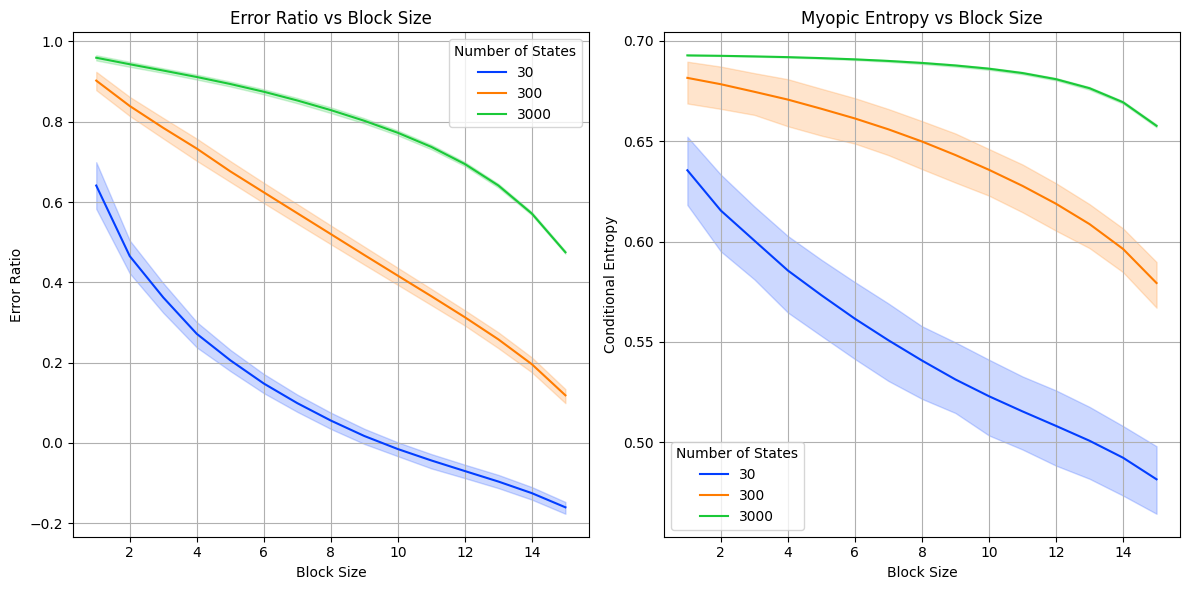

In [97]:
extract_and_plot_data(num_states_list=CONFIG['NUM_STATES_LIST'], hdf5_filepath_base=CONFIG['HDF5_BASE_PATH'])